The code cell below is used to import Reviews.csv. It checks for null values in dataframe. Plot graphs for Distribution of ratings, Helpfullness Numerator and Helpfullness Denominator.

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

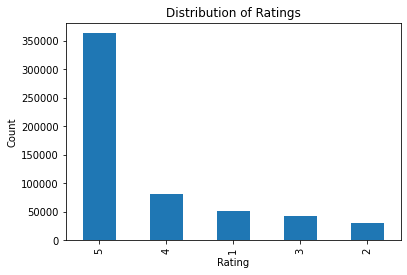

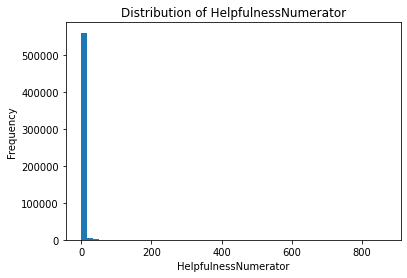

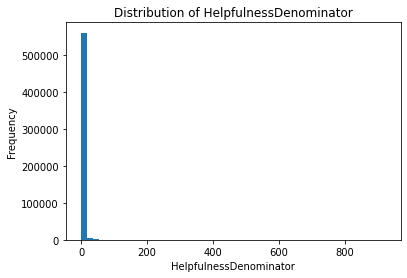

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv') 

# Print first few rows of dataframes
print(df.head())

# Print summary of dataframe
print(df.info())

# Check missing values in df
print(df.isnull().sum())

# Plot the distribution of ratings (1-5) from dataframe
df['Score'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#Plot a histogram for HelpfulnessNumerator and HelpfulnessDenominator from df.

df['HelpfulnessNumerator'].plot(kind='hist', bins=50)
plt.title('Distribution of HelpfulnessNumerator')
plt.xlabel('HelpfulnessNumerator')
plt.show()

df['HelpfulnessDenominator'].plot(kind='hist', bins=50)
plt.title('Distribution of HelpfulnessDenominator')
plt.xlabel('HelpfulnessDenominator')
plt.show()


The code cell below first select first 100000 rows from dataframe, then remove unnecessary columns from dataframe,then handle missing values , The central part of this code is the preprocessing of the 'Text' column: it converts the text to lowercase, removes non-alphabetic characters, tokenizes the sentences, and eliminates stopwords. Following this, the preprocessed text is transformed into a vector representation using the TF-IDF.

In [2]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv') 
# Select first 100000 rows 
df = df.head(100000)

# Drop unnecessary columns
df = df.drop(['Id', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1)

# Missing value handling 
df = df.dropna()

# Preprocess 'Text' column
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Delete non-alphabetic characters
    text = re.sub('[^a-z]', ' ', text)

    # Tokenization of text.
    words = word_tokenize(text)

    # Deleting stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    return ' '.join(words)

df['Text'] = df['Text'].apply(preprocess_text)

# Convert 'Text' into tf-idf vectors
vectorizer = TfidfVectorizer(max_features=1000) # Limited features to 1000 to prevent memory related issues
df['Text_Tfidf'] = list(vectorizer.fit_transform(df['Text']).toarray())

print(df.head())


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


    ProductId          UserId  Score        Time                Summary  \
0  B001E4KFG0  A3SGXH7AUHU8GW      5  1303862400  Good Quality Dog Food   
1  B00813GRG4  A1D87F6ZCVE5NK      1  1346976000      Not as Advertised   
2  B000LQOCH0   ABXLMWJIXXAIN      4  1219017600  "Delight" says it all   
3  B000UA0QIQ  A395BORC6FGVXV      2  1307923200         Cough Medicine   
4  B006K2ZZ7K  A1UQRSCLF8GW1T      5  1350777600            Great taffy   

                                                Text  \
0  bought several vitality canned dog food produc...   
1  product arrived labeled jumbo salted peanuts p...   
2  confection around centuries light pillowy citr...   
3  looking secret ingredient robitussin believe f...   
4  great taffy great price wide assortment yummy ...   

                                          Text_Tfidf  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.24458373427228455, 0.0,...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

The code cell below first loads the dataset , then Create mapper from product ID to index , then Tranform the productID in the interaction_matrix into indices, then Transform interaction_matrix to scipy sparse matrix, then Split data into training set and testing set, followed by initilization of LightFM model, then train model and compute precision and recall at k.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from scipy.sparse import coo_matrix, csr_matrix

# Load the dataset
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv', nrows=100000) 

# developing user- & item-interaction matrix
interaction_matrix = pd.pivot_table(df, values='Score', index='UserId', columns='ProductId', fill_value=0)

# Create mapper from product ID to index
item_dict ={}
df_n = df[df['ProductId'].isin(interaction_matrix.columns)]
df_n = df_n.sort_values('ProductId')
item_dict = dict(zip(df_n['ProductId'], list(df_n['ProductId'].astype('category').cat.codes)))

# Tranform the productID in the interaction_matrix into indices.
interaction_matrix = interaction_matrix.rename(columns=item_dict)

# Transform interaction_matrix to scipy sparse matrix
interaction_matrix_csr = csr_matrix(interaction_matrix.values)

# Split data into training set and testing set
test = interaction_matrix_csr.copy()
test[test != 0] = 1
train = interaction_matrix_csr - test

# Initialize of model
model = LightFM(loss='warp')

# Train model
model.fit(train, epochs=30, num_threads=2)

# Compute precision at k
train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, test, k=5).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

# Compute recall at k
train_recall = recall_at_k(model, train, k=5).mean()
test_recall = recall_at_k(model, test, k=5).mean()

print('Recall: train %.2f, test %.2f.' % (train_recall, test_recall))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Precision: train 0.12, test 0.11.
Recall: train 0.43, test 0.39.


Precision at k: This metrices tell us about how many of the top k recommendation are actually relevant to users.From the results we can say that on average arounf 12% of the top 5 recommended products for training set and around 11% for test set are relevant to users.

Recall at k: This tells us about how many actual relevant items are present in top k recommendation. From the result we can observe that for training set , it is aprox 43% of relevant items in top 5 recommendation and for test set, it is 39%.


The code cell below develop basic SVD model for testing purpose to check wheather everything is working fine on dataset or not and then compute RMSE score.

In [4]:
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# Load dataset
reader = Reader(rating_scale=(1, 5))  
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']], reader)

# Split dataset in train and test
trainset, testset = train_test_split(data, test_size=.25)

# Use the SVD algorithm.
algo = SVD()

# Train algorithm on trainset and predicting rating for testset.
algo.fit(trainset)

# Test rained model
predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 1.2177


1.2176765670188174

Output shows that RMSE of model is 1.2176765670188174 for a rating of 1-5.

The code below uses previously trained basic SVD Model and predict a user rating for a specific product.The code essentially predicts and shows the expected rating a user would give a specific product based on prior data.

In [6]:
predicted_rating = algo.predict("A327PCT23YH90", "B0009XLVG0")
print(predicted_rating.est)

3.257795026666391


The output shows that for a product "B0009XLVG0" the user "A327PCT23YH90" will give rating of aprox 3.257795026666391.

The code cell below measures two distinct accuracy metrics on the given set of predictions using the surprise library. First is MAE which tell the difference between predictes vs actuall rating.Second is FCP which measure that evaluates the proportion of correctly ordered prediction pairs.

In [7]:
accuracy.mae(predictions)
accuracy.fcp(predictions)

MAE:  0.9466
FCP:  0.5895


0.5894564828111243

The code cell below initilize a The code cell is initializing a Singular Value Decomposition (SVD) model from the Surprise library with specific hyperparameters.
n_factors=50: It sets the number of latent factors to use in model.
n_epochs=20: It sets the number of epochs the SVD algorithm will run.
lr_all=0.005: It sets the learning rate for all the parameters in the model.


In [8]:
algo = SVD(n_factors=50, n_epochs=20, lr_all=0.005)


The code cell below uses Surprise library, it sets up to evaluate multiple collaborative filtering algorithms for recommendation, namely SVD, three variations of K-Nearest Neighbors (KNNBasic, KNNWithMeans, KNNWithZScore), and NMF. 
Each algorithm is cross-validated using 3-fold process and finds RMSE on this data. The average RMSE of each algorith is printed as output.

In [11]:
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic, KNNWithMeans, KNNWithZScore, NMF
from surprise.model_selection import cross_validate
import numpy as np

# Subset the dataframe for the first 100,000 rows
df = df.iloc[:100000]

# Use actual names of columns in your DataFrame
user_id = 'UserId'
product_id = 'ProductId'
rating = 'Score'

# Reader object; rating_scale should match the scale of ratings in your DataFrame
reader = Reader(rating_scale=(1, 5))

# Load the data from the DataFrame
data = Dataset.load_from_df(df[[user_id, product_id, rating]], reader)

# Adjust KNN algorithm parameters and use cosine similarity
sim_options = {
    'name': 'cosine',
    'user_based': False  # Set to `True` if you want user-based CF
}

# Define the algorithms
algorithms = {
    "SVD": SVD(),
    "KNNBasic": KNNBasic(sim_options=sim_options),
    "KNNWithMeans": KNNWithMeans(sim_options=sim_options),
    "KNNWithZScore": KNNWithZScore(sim_options=sim_options),
    "NMF": NMF()
}

# Apply cross validation for each algorithm and print out the results
for name, algo in algorithms.items():
    cv_results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    print(f'{name}:')
    print('-' * 40)
    print(f"Test RMSE: {np.mean(cv_results['test_rmse'])}")
    print('\n')


SVD:
----------------------------------------
Test RMSE: 1.2266509196936053


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic:
----------------------------------------
Test RMSE: 1.2309556052718065


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNWithMeans:
----------------------------------------
Test RMSE: 1.2383107077704538


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNWithZScore:
----------------------------------------
Test RMSE: 1


1. **SVD (Singular Value Decomposition):**
   - RMSE: 1.2266509196936053

2. **KNNBasic:**
   - RMSE:  1.2309556052718065
   
3. **KNNWithMeans:**
   - RMSE: 1.2383107077704538

4. **KNNWithZScore:**
   - RMSE: 1.240938024186249

5. **NMF (Non-negative Matrix Factorization):**
   - RMSE: 1.2926665307522793

In summary, **SVD** performed the best among the algorithms tested, with the lowest RMSE. 

The code cells below uses these hyperparameters 'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.01],'reg_all': [0.2, 0.4, 0.6] and finds on which hypterparameters SVD algo will run best on basis of thier RMSE.

In [12]:
from surprise.model_selection import GridSearchCV
# Define the parameter grid

param_grid = {
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Use GridSearchCV with SVD
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fit the grid search to the data
gs.fit(data)

# Get the best parameters
best_params = gs.best_params['rmse']

print(f"Best parameters for RMSE: {best_params}")

# Get the best score
best_score = gs.best_score['rmse']

print(f"Best RMSE score: {best_score}")



Best parameters for RMSE: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
Best RMSE score: 1.2170725058337772


The output shows that on these hyperparameters SVD model performs best.Best parameters for RMSE: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
Best RMSE score: 1.2170725058337772

The code cell below uses Best parameters for RMSE: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} to predict rating from particular product by user will give and calculate RMSE of output.

In [13]:
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV

# Load data
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv', nrows=100000)

user_id = 'UserId'
product_id = 'ProductId'
rating = 'Score'


reader = Reader(rating_scale=(1, 5)) 
data = Dataset.load_from_df(df[[user_id, product_id, rating]], reader)  # Load data from DF

param_grid = {
    'n_epochs': [20], 
    'lr_all': [0.01],
    'reg_all': [0.2]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# RMSE score
print(gs.best_score['rmse'])

# combination of parameters that give best RMSE score
print(gs.best_params['rmse'])

#making predictions using the algo.predict() method
algo = gs.best_estimator['rmse']

# Train on the dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

# To predict the rating user 'anyuser from data' would give to item 'any item in dataset':
pred = algo.predict('A3KLWF6WQ5BNYO', 'B001GVISJM', verbose=True)
print(pred.est)



1.2180160507724898
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
user: A3KLWF6WQ5BNYO item: B001GVISJM r_ui = None   est = 3.46   {'was_impossible': False}
3.4559131367121414


The output shows that RMSE is 1.2180160507724898 for user A3KLWF6WQ5BNYO and item B001GVISJM,
est = 3.45 is the estimated rating that the model predicts the user would give to the item.
{'was_impossible': False} indicates that the prediction was possible (i.e., it didn't encounter an issue like a lack of data for making a prediction). 

The code cell below for SVD model with hyperparameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} finds out RMSE, F1 score, Precision and Recall.

In [188]:
import pandas as pd
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

# Load data
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv', nrows=100000)


user_id = 'UserId'
product_id = 'ProductId'
rating = 'Score'

reader = Reader(rating_scale=(1, 5))  
data = Dataset.load_from_df(df[[user_id, product_id, rating]], reader) 

param_grid = {
    'n_epochs': [20], 
    'lr_all': [0.01],
    'reg_all': [0.2]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# finding RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave RMSE score
print(gs.best_params['rmse'])

# Use the best model
algo = gs.best_estimator['rmse']

# Train on the dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

# Test on the test set
trainset, testset = train_test_split(data, test_size=0.25)
predictions = algo.test(testset)

# Convert actual and predicted ratings into binary labels
threshold = 4.0 
actual = [1 if r >= threshold else 0 for (_, _, r) in testset]
predicted = [1 if est >= threshold else 0 for (_, _, _, est, _) in predictions]

# Calculates Precision, Recall, F1 Score
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Scor1e: {f1:.4f}")


1.217102048662859
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
Precision: 0.9893
Recall: 0.9041
F1 Score: 0.9448


Using the pickle library, the code serialises and saves the trained model algorithm to a file called "trained_model.pkl."

In [14]:
import pickle

# `algo` is our trained model
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(algo, f)

The programme first loads a model from "trained_model.pkl" and tests the prediction function for a certain user and item. It next imports a stored model from a file using the pickle programme and predicts a rating for a given user-item combination.

In [15]:
import pickle

def load_model(model_file):
    with open(model_file, 'rb') as f:
        return pickle.load(f)

def predict_rating(user_id, item_id, model):
    prediction = model.predict(user_id, item_id)
    return prediction.est

# Load the model
model = load_model('trained_model.pkl')

# Test the function
user_id = 'A31OQO709M20Y7'
item_id = 'B003F6UO7K'
print(predict_rating(user_id, item_id, model))



4.626440496550361


The trained model's predicted rating of 4.62 indicates that user 'A31OQO709M20Y7' would give to product'B003F6UO7K'.

The code cell below calculates the average accuracy and recall for user-item rating predictions at a certain cutoff k, taking into account only ratings that are higher than a predetermined threshold.

In [18]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """It Returns precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sorting user's ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant products
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Calculate precision and recall over all users
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)


The code cell below produces overlapping histograms to better compare the distributions of the actual and Predicted user-item ratings.

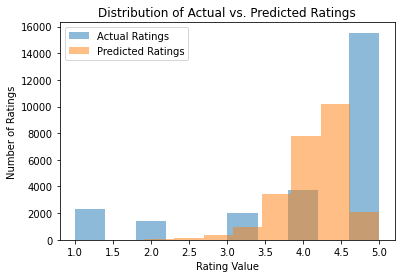

In [19]:
import matplotlib.pyplot as plt

# Ploating Actual ratings
actual_ratings = [true_r for (_, _, true_r, _, _) in predictions]
plt.hist(actual_ratings, alpha=0.5, label='Actual Ratings')

# Ploating Predicted ratings
predicted_ratings = [est for (_, _, _, est, _) in predictions]
plt.hist(predicted_ratings, alpha=0.5, label='Predicted Ratings')

plt.legend(loc='upper left')
plt.title('Distribution of Actual vs. Predicted Ratings')
plt.xlabel('Rating Value')  
plt.ylabel('Number of Ratings')
plt.show()



The code cell below print first 10 predictions based on model.

In [20]:
print(predictions[:10]) 


[Prediction(uid='A1NCBHQ4VIES48', iid='B0015R9BQG', r_ui=5.0, est=4.331162939456401, details={'was_impossible': False}), Prediction(uid='AIW77UMHDBGLU', iid='B002GJ9JWS', r_ui=2.0, est=3.946170299926893, details={'was_impossible': False}), Prediction(uid='A1F7NPONOI6KP7', iid='B002PI82P0', r_ui=1.0, est=3.7979393692093217, details={'was_impossible': False}), Prediction(uid='A3NXMA1A5761IN', iid='B000KOSDY6', r_ui=5.0, est=4.526733833165899, details={'was_impossible': False}), Prediction(uid='A3NHUQ33CFH3VM', iid='B000ER6YO0', r_ui=3.0, est=3.3079871068551148, details={'was_impossible': False}), Prediction(uid='A3SIN3XBXYNMPB', iid='B0012YEKCM', r_ui=5.0, est=4.160846118070443, details={'was_impossible': False}), Prediction(uid='A1Z7UMW0Q2333R', iid='B000QV4U4U', r_ui=5.0, est=4.438783163714065, details={'was_impossible': False}), Prediction(uid='ARX7Z3NI6O0F7', iid='B004BW45Q8', r_ui=5.0, est=4.259346675278836, details={'was_impossible': False}), Prediction(uid='A1O229NVVDJUX2', iid='B

The code below tunes the hyperparameters of an SVD recommendation model, trains the best model on a dataset, and then compares the popularity ranks of its top 5 item suggestions for a random subset of users against a set of random recommendations, using a t-test for statistical significance.

In [22]:
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from collections import defaultdict
from scipy.stats import ttest_ind
import random

# Load 100,000 rows of dataset
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv', nrows=100000)


user_id = 'UserId'
product_id = 'ProductId'
rating = 'Score'

# Load data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[[user_id, product_id, rating]], reader)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_epochs': [20],
    'lr_all': [0.01],
    'reg_all': [0.2]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Get best model
best_model = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# Train model on full dataset
trainset = data.build_full_trainset()
best_model.fit(trainset)

# Create Popularity Rankings
item_popularity = df.groupby(product_id).size().sort_values(ascending=False)
popularity_rankings = item_popularity.index.tolist()

# Function to get top N predictions
def get_top_n(predictions, n=10):
    
    '''Make the top-N item suggestions for each user.
      Predictions (list of Prediction objects), parameters: a group of forecasted ratings.
     n(int): The desired number of highly rated products to recommend to each user, with a default value of 10.
      Outcome:
     A dictionary with keys that are the user's (raw) ids and values that are lists of tuples with the following combinations: [(item's raw id, projected rating),...], with a maximum of 'n' items.'''
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Select a random subset of users
subset_users = random.sample(trainset.all_users(), 100)

# Generate a testset for the selected users
subset_testset = [(uid, iid, trainset.global_mean) for uid in subset_users for iid in trainset.all_items()]

# Generate predictions for the subset
subset_predictions = best_model.test(subset_testset)

# Get top 5 recommendations
top_n = get_top_n(subset_predictions, n=5)

# Extract item ids from recommendations
recommendations_item_ids = {trainset.to_raw_uid(uid): [trainset.to_raw_iid(iid) for (iid, _) in user_ratings] for uid, user_ratings in top_n.items()}

# Analyze the Recommendations
recommendation_ranks = [[popularity_rankings.index(item_id) for item_id in user_rec] for user_rec in recommendations_item_ids.values()]

# Compare with Random Recommendations
random_recommendations = [random.choices(popularity_rankings, k=5) for _ in range(len(recommendations_item_ids))]
random_ranks = [[popularity_rankings.index(item_id) for item_id in user_rec] for user_rec in random_recommendations]

# Statistical Tests
t_stat, p_value = ttest_ind(recommendation_ranks, random_ranks)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


1.2178472614017215
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
T-statistic: [10.63668615  5.92446186  2.98859666 16.78226198 -7.17150981]
P-value: [3.43842139e-21 1.36771019e-08 3.15746926e-03 6.69880814e-40
 1.44466403e-11]


The code cell below for every user,it obtains the top five products that are highly recommended, shows those products together with the ratings that are expected, and then displays the user's prior rating or purchase history.

In [23]:
# Get top 5 recommendations for each user
top_n = get_top_n(subset_predictions, n=5)


for uid, user_ratings in top_n.items():
    print("\nUser:", trainset.to_raw_uid(uid))
    print("Top 5 recommendations:")
    for (iid, rating) in user_ratings:
        print("Product ID:", trainset.to_raw_iid(iid), "Predicted Rating:", rating)
        
    # Display past behavior of the user
    user_history = df[df[user_id] == trainset.to_raw_uid(uid)]
    print("\nUser history:")
    print(user_history)



User: A1HW6MXJT4Y7YL
Top 5 recommendations:
Product ID: B001E4KFG0 Predicted Rating: 4.15263
Product ID: B00813GRG4 Predicted Rating: 4.15263
Product ID: B000LQOCH0 Predicted Rating: 4.15263
Product ID: B000UA0QIQ Predicted Rating: 4.15263
Product ID: B006K2ZZ7K Predicted Rating: 4.15263

User history:
          Id   ProductId          UserId             ProfileName  \
90013  90014  B0046GRD0O  A1HW6MXJT4Y7YL  J. Shepherd "jenithea"   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
90013                     0                       0      5  1349481600   

                           Summary  \
90013  delicious and not too sweet   

                                                    Text  
90013  If you like extremely sweet things, like fudge...  

User: AJ5DZEHLRHP9V
Top 5 recommendations:
Product ID: B001E4KFG0 Predicted Rating: 4.15263
Product ID: B00813GRG4 Predicted Rating: 4.15263
Product ID: B000LQOCH0 Predicted Rating: 4.15263
Product ID: B000UA0QIQ 

The output includes a brief history of each user's product interactions as well as the top product suggestions for that user. For instance:
User: A3IR834T7AROBT:

Top 5 recommendations: The model gives 5 products to this user and all the products have the same predicted rating of 4.15263.
User history: This section displays products that this user, denoted as "Ed," has previously rated or interacted with. Each product's review details are shown, such as the product ID, the score given by the user, the time of the review, and the review's summary and text. For example, Ed has previously given a 5-star rating to product "B003VXFK44" with the summary "Pleasant, smooth and flavorful cup of coffee."
In conclusion, the output offers insights into the products recommended to particular users based on the model's predictions and compares these suggestions with the user's previous interactions to understand and analyse the relevance and accuracy of the recommendations. 





The code below again discover the ideal combination of parameters that minimises root mean square error (RMSE) during cross-validation, the code conducts hyperparameter tuning on the SVD method using GridSearchCV from the Surprise library.

In [185]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [20, 30],  # No. of iterations 
    'lr_all': [0.002, 0.005, 0.01],  # Learning rates
    'reg_all': [0.02, 0.1, 0.2]  # Regularization terms
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


1.1975680546763705
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}


The output shows that for new better hyperparameters 
RMSE is  `1.1955225489888262` with `{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}`.


The code cell below sets up the SVD model with the best parameters, trains it on a training set, tests it on a test set, and then reports the root mean square error (RMSE) of its predictions.

In [186]:

# Compile SVD model with best parameters
model = SVD(n_epochs=30, lr_all=0.01, reg_all=0.02)

# Training on the trainset
model.fit(trainset)

# Predict and compute RMSE 
predictions = model.test(testset)
accuracy.rmse(predictions)


RMSE: 1.1814


1.1813625680621598

The code cell below run the SVD model with parameters {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and finds RMSE,Precision, Recall and F1 Score.

In [189]:
from surprise import accuracy, SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.25)

# Complie SVD model with following parameters
model = SVD(n_epochs=30, lr_all=0.01, reg_all=0.02)

# Train model on the trainset
model.fit(trainset)

# Compute RMSE on testset
predictions = model.test(testset)
print("RMSE:", accuracy.rmse(predictions))

threshold = 4.0 
actual = [1 if r >= threshold else 0 for (_, _, r) in testset]
predicted = [1 if est >= threshold else 0 for (_, _, _, est, _) in predictions]

# Calculate Precision, Recall, F1 Score
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


RMSE: 1.1810
RMSE: 1.1809891560964174
Precision: 0.8595
Recall: 0.7812
F1 Score: 0.8185


The code cell below creates predictions for all the objects in the training set, turns them into a DataFrame, determines the absolute error for each prediction, and prints the 10 predictions with the biggest mistakes.

In [182]:
# Get all predictions
predictions = model.test(trainset.build_testset())

# Convert predictions to df
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

# Calculate error in prediction
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

# Show worst predictions
print(df_predictions.sort_values(by='err', ascending=False).head(10))


                  uid         iid  rui       est                    details  \
26051   A4JSQFCKVKX2A  B004HOLD4W  1.0  3.427924  {'was_impossible': False}   
26054   A4JSQFCKVKX2A  B001EQ4RBM  1.0  3.283807  {'was_impossible': False}   
40205   ARRNOA2H9V4ZZ  B004SRH2B6  5.0  2.780987  {'was_impossible': False}   
16275  A165ME21JE98VF  B0089SPEO2  1.0  3.187323  {'was_impossible': False}   
17505  A1SB8CXAUIKT8X  B000FBQ50I  2.0  4.152606  {'was_impossible': False}   
33951  A2IRI9FQ3Y2THO  B0030VBRIU  1.0  3.139065  {'was_impossible': False}   
46514   AQAE1BZM6GQ2I  B0030VBQOK  1.0  3.127932  {'was_impossible': False}   
30082  A2GO0AIHB846UX  B004SRH2B6  5.0  2.876552  {'was_impossible': False}   
17511  A1SB8CXAUIKT8X  B000FBO9LK  2.0  4.123209  {'was_impossible': False}   
6049   A1TYQC1QMX1117  B000FNB3AI  1.0  3.122331  {'was_impossible': False}   

            err  
26051  2.427924  
26054  2.283807  
40205  2.219013  
16275  2.187323  
17505  2.152606  
33951  2.139065  
4651

The output displays the 10 predictions from the model with the biggest errors. The user ID (uid), item ID (iid), actual rating (rui), estimated rating (est), information about the prediction (details), and the absolute difference between the actual and estimated ratings (err) are all provided for each prediction. The predictions are arranged in decreasing order of error to highlight the areas where the model's predictions were most off from actual user ratings.


The code below divides the data into training and test sets, builds a better SVD model on the training data, and then uses histograms to show how the test set's actual ratings compare to those that were predicted.

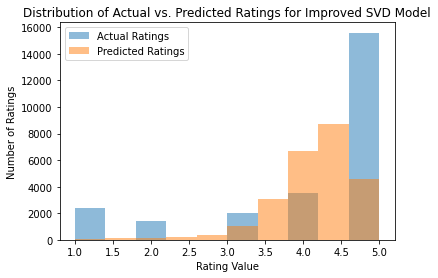

In [28]:
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

trainset, testset = train_test_split(data, test_size=0.25)

# Run SVD model with new better parameters.
model_improved = SVD(n_epochs=30, lr_all=0.01, reg_all=0.02)  

# Train model
model_improved.fit(trainset)

# Geting predictions
predictions_improved = model_improved.test(testset)

# Actual ratings
actual_ratings_improved = [true_r for (_, _, true_r, _, _) in predictions_improved]
plt.hist(actual_ratings_improved, alpha=0.5, bins=10, label='Actual Ratings')

# Predicting and ploating ratings.
predicted_ratings_improved = [est for (_, _, _, est, _) in predictions_improved]
plt.hist(predicted_ratings_improved, alpha=0.5, bins=10, label='Predicted Ratings')

plt.legend(loc='upper left')
plt.title('Distribution of Actual vs. Predicted Ratings for Improved SVD Model')
plt.xlabel('Rating Value')   # Label for x-axis
plt.ylabel('Number of Ratings')   # Label for y-axis
plt.show()


The code cell below compare old SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} and new improved SVD model with parameters {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} in tabular form.

In [193]:
import pandas as pd

models = ['Old SVD', 'New SVD']
rmse = [1.217102048662859, 1.1809891560964174]
precision = [0.9893, 0.8595]
recall = [0.9041, 0.7812]
f1 = [0.9448, 0.8185]

df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

print(df)


     Model      RMSE  Precision  Recall  F1 Score
0  Old SVD  1.217102     0.9893  0.9041    0.9448
1  New SVD  1.180989     0.8595  0.7812    0.8185


The code cell below compare old SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} and new improved SVD model with parameters {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and showing difference by graph.

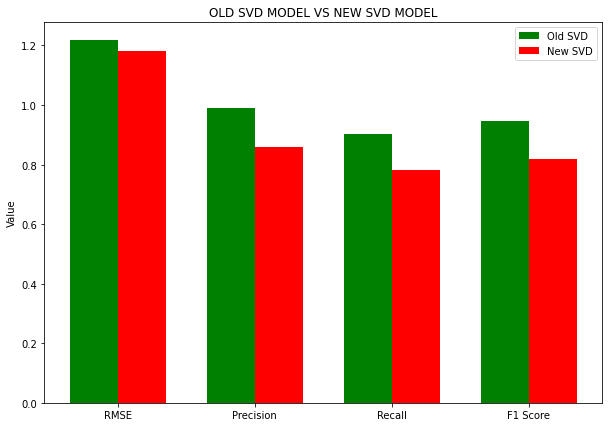

In [196]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['RMSE', 'Precision', 'Recall', 'F1 Score']
old_svd_values = [1.217102048662859, 0.9893, 0.9041, 0.9448]
new_svd_values = [1.1809891560964174, 0.8595, 0.7812, 0.8185]

x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, old_svd_values, width, label='Old SVD', color='Green')
rects2 = ax.bar(x + width/2, new_svd_values, width, label='New SVD', color='red')


ax.set_ylabel('Value')
ax.set_title('OLD SVD MODEL VS NEW SVD MODEL')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Plot graph that is showing difference.
plt.show()


The code cell below compare old SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} and new improved SVD model with parameters {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} by showing comparison by heatmap.

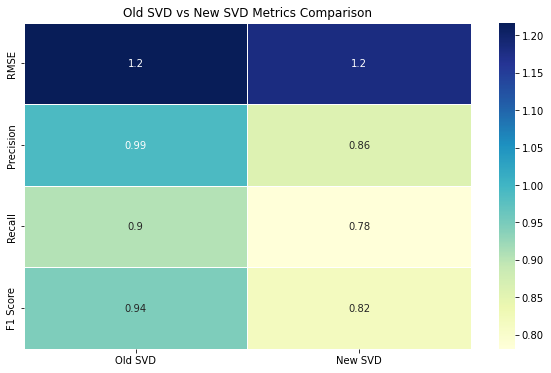

In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['RMSE', 'Precision', 'Recall', 'F1 Score']
old_svd_values = [1.217102048662859, 0.9893, 0.9041, 0.9448]
new_svd_values = [1.1809891560964174, 0.8595, 0.7812, 0.8185]


metrics_df = pd.DataFrame({'Old SVD': old_svd_values, 'New SVD': new_svd_values}, index=labels)

# Creating heatmap
plt.figure(figsize=(10,6))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5)
plt.title("Old SVD vs New SVD Metrics Comparison")
plt.show()


The code cell below trians two SVD models (old and improved(new)) , predict ratings and then plot graph for the distributions of actual vs. predicted ratings for both models.

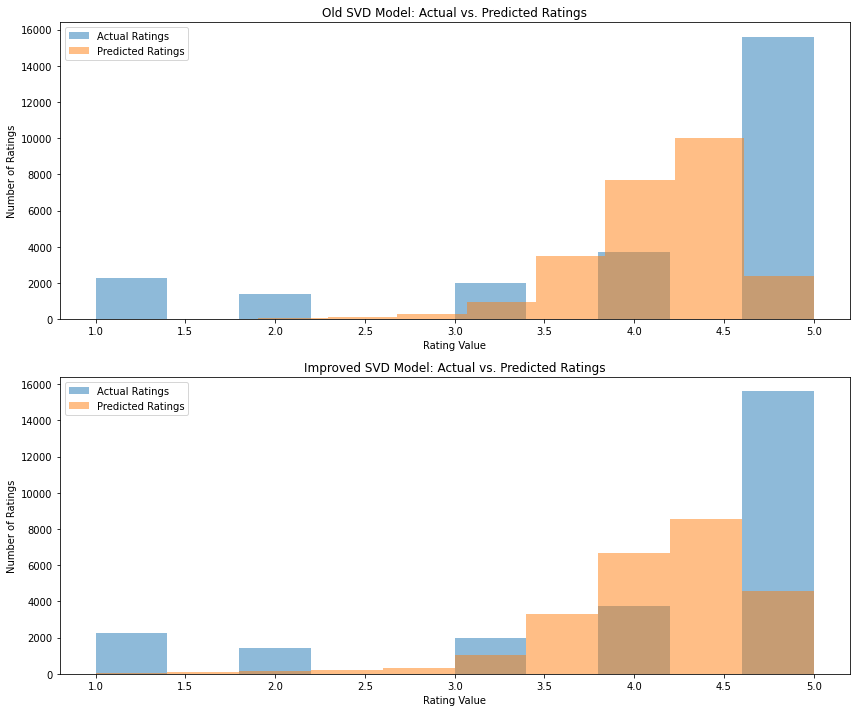

In [33]:
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

trainset, testset = train_test_split(data, test_size=0.25)

# Define old and new(improved) SVD models
model_old = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)
model_improved = SVD(n_epochs=30, lr_all=0.01, reg_all=0.02)

# Train the models
model_old.fit(trainset)
model_improved.fit(trainset)

# Doing prediction
predictions_old = model_old.test(testset)
predictions_improved = model_improved.test(testset)

# Actual ratings for both models
actual_ratings_old = [true_r for (_, _, true_r, _, _) in predictions_old]
actual_ratings_improved = [true_r for (_, _, true_r, _, _) in predictions_improved]

# Predicted ratings by both models
predicted_ratings_old = [est for (_, _, _, est, _) in predictions_old]
predicted_ratings_improved = [est for (_, _, _, est, _) in predictions_improved]

# Ploting graph 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# old model
ax[0].hist(actual_ratings_old, alpha=0.5, bins=10, label='Actual Ratings')
ax[0].hist(predicted_ratings_old, alpha=0.5, bins=10, label='Predicted Ratings')
ax[0].legend(loc='upper left')
ax[0].set_title('Old SVD Model: Actual vs. Predicted Ratings')
ax[0].set_xlabel('Rating Value')
ax[0].set_ylabel('Number of Ratings')

# improved new model
ax[1].hist(actual_ratings_improved, alpha=0.5, bins=10, label='Actual Ratings')
ax[1].hist(predicted_ratings_improved, alpha=0.5, bins=10, label='Predicted Ratings')
ax[1].legend(loc='upper left')
ax[1].set_title('Improved SVD Model: Actual vs. Predicted Ratings')
ax[1].set_xlabel('Rating Value')
ax[1].set_ylabel('Number of Ratings')

plt.tight_layout()
plt.show()


The code below is installing python libraries that we are using later in our code.

In [40]:
pip install pandas numpy tensorflow scikit-learn



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The code below is updating installed python libaries

In [41]:
 pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


The code below is installing python library tensorflow_addons.

In [86]:
!pip install tensorflow_addons


  Obtaining dependency information for tensorflow_addons from https://files.pythonhosted.org/packages/37/0d/dc555976a792c6b2f6539de2f38fc73042ccd4705788922ad10f245a94d8/tensorflow_addons-0.21.0-cp39-cp39-macosx_10_14_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 15.6 MB/s eta 0:00:0000:0100:01


The code below is installing python library keras-tuner

In [97]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.5 MB/s eta 0:00:00


The code below is loading first 100000 rows from Reviews.csv to df, then converting data into categorical data and then performing train-test split.

In [209]:
import pandas as pd
import numpy as np

# Loading of dataset
df = pd.read_csv('/Users/himanshu/Desktop/msc/Reviews.csv')
df = df[['UserId', 'ProductId', 'Score']].head(100000)

# Convert user and product ID into categorical data.
df['UserId'] = df['UserId'].astype("category").cat.codes.values
df['ProductId'] = df['ProductId'].astype("category").cat.codes.values

# Train-test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)


The code cell is checking missing values in loaded df.

In [210]:

missing_values = df.isnull().sum()
print(missing_values)


UserId       0
ProductId    0
Score        0
dtype: int64


The code cell below checks duplicate value in df.

In [211]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows = {duplicate_rows}")

# Remove duplicate rows
df = df.drop_duplicates()


Number of duplicate rows = 1100


The code cells below delete rows with duplicate valued from df.

In [212]:
df = df.drop_duplicates()


The code cells below checks for the rows with duplicate values again after droping duplicate rows.

In [213]:
duplicate_rows_after = df.duplicated().sum()
print(f"Number of duplicate rows after removal = {duplicate_rows_after}")


Number of duplicate rows after removal = 0


The code calculates the relative frequency of each unique score in the Score column of the df DataFrame. The output displays each score's percentage representation in the dataset.

In [214]:
# Check the distribution of scores
print(df['Score'].value_counts(normalize=True))


5    0.622983
4    0.146825
1    0.093175
3    0.080961
2    0.056057
Name: Score, dtype: float64


The output depicts that percentage distribution of scores in the dataset:

- About 62.3% of the reviews have a score of 5.
- 14.7% have a score of 4.
- 9.3% have a score of 1.
- 8.1% have a score of 3.
- 5.6% have a score of 2.

**-** The code cell below develop and trains a hybrid neural collaborative filtering model to forecast product ratings using Generalised Matrix Factorization (GMF) and Multi-Layer Perceptron (MLP). The MLP component strengthens the model by concatenating these embeddings and processing them through dense neural layers, while the GMF part captures the latent links by multiplying user and object embeddings. The final step is to combine, flatten, and analyse both components to create a binary prediction that expresses whether a consumer would find a product appealing. The Adam optimizer, a special F1 score measure, and binary cross-entropy loss are used to build the model.
**-** Using callbacks for early stopping and learning rate modification, the model is trained using prepared data that has been divided into training and testing sets. Both accuracy and loss are tracked throughout training for both training and validation datasets.
**-** After Training raining completion, the model's performance is visualized, plotting accuracy and loss across epochs to evaluate its effectiveness and performance.



Epoch 1/35
862/862 [==============================] - 24s 26ms/step - loss: 0.8316 - accuracy: 0.7557 - f1_score: 0.8416 - val_loss: 0.5721 - val_accuracy: 0.9251 - val_f1_score: 0.9516 - lr: 0.0010
Epoch 2/35
862/862 [==============================] - 19s 23ms/step - loss: 0.5437 - accuracy: 0.8948 - f1_score: 0.9245 - val_loss: 0.5954 - val_accuracy: 0.8893 - val_f1_score: 0.9262 - lr: 0.0010
Epoch 3/35
862/862 [==============================] - 20s 23ms/step - loss: 0.5618 - accuracy: 0.8910 - f1_score: 0.9210 - val_loss: 0.5062 - val_accuracy: 0.9189 - val_f1_score: 0.9466 - lr: 0.0010
Epoch 4/35
862/862 [==============================] - 22s 25ms/step - loss: 0.4504 - accuracy: 0.9167 - f1_score: 0.9395 - val_loss: 0.3921 - val_accuracy: 0.9362 - val_f1_score: 0.9579 - lr: 0.0010
Epoch 5/35
862/862 [==============================] - 22s 25ms/step - loss: 0.3738 - accuracy: 0.9273 - f1_score: 0.9469 - val_loss: 0.3776 - val_accuracy: 0.9172 - val_f1_score: 0.9440 - lr: 0.0010
Epoch

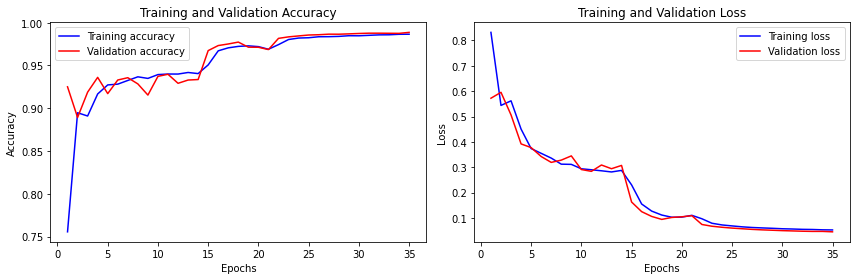

In [216]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Model, regularizers, callbacks
from tensorflow.keras.layers import (Embedding, Input, Flatten, Multiply, Concatenate, Dense, 
                                     Dropout, BatchNormalization)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

num_users = df['UserId'].nunique()
num_items = df['ProductId'].nunique()
embedding_dim = 40
reg_lambda = 0.001

# GMF part
user_input = Input(shape=(1,), dtype='int32', name='user_input')
item_input = Input(shape=(1,), dtype='int32', name='item_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, 
                           embeddings_initializer='glorot_normal', 
                           embeddings_regularizer=regularizers.l2(reg_lambda))(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, 
                           embeddings_initializer='glorot_normal', 
                           embeddings_regularizer=regularizers.l2(reg_lambda))(item_input)
gmf_mul = Multiply()([user_embedding, item_embedding])

# MLP part
mlp_concat = Concatenate()([user_embedding, item_embedding])
mlp_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_lambda))(mlp_concat)
mlp_layer = BatchNormalization()(mlp_layer)
mlp_layer = Dropout(0.3)(mlp_layer)
mlp_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_lambda))(mlp_layer)
mlp_layer = BatchNormalization()(mlp_layer)
mlp_layer = Dropout(0.3)(mlp_layer)
mlp_layer = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg_lambda))(mlp_layer)

# Merge GMF + MLP
merge_vector = Concatenate()([gmf_mul, mlp_layer])
flatten_layer = Flatten()(merge_vector)
output_layer = Dense(1, activation='sigmoid')(flatten_layer)

model = Model([user_input, item_input], output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

def f1_score(y_true, y_pred):
    y_pred = tf.math.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true * y_pred, dtype=tf.float32))
    fp = tf.math.reduce_sum(tf.cast((1-y_true) * y_pred, dtype=tf.float32))
    fn = tf.math.reduce_sum(tf.cast(y_true * (1-y_pred), dtype=tf.float32))
    
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn + 1e-16)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-16)
    return f1

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Data Augmentation: Adding negative samples
neg_samples = df[df['Score'] < 4].sample(frac=0.5)
df_augmented = pd.concat([df, neg_samples])

X_train = [df_augmented['UserId'].values, df_augmented['ProductId'].values]
y_train = np.array([1 if i >= 4 else 0 for i in df_augmented['Score'].values])
X_test = [test['UserId'].values, test['ProductId'].values]
y_test = np.array([1 if i >= 4 else 0 for i in test['Score'].values])

# Code for running model upto 35 epochs.
history = model.fit(X_train, y_train, epochs=35, batch_size=128, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The output shows the result on following variables.

1.Epochs- It displays the number of times the neural network processed on dataset. Out of  35 epochs, the neural network has completed 34 in this output.

2.862/862- This shows that 862 batches of data were processed in each epoch. This suggests that the full dataset is split into 862 batches.

From epochs 1 to 34, the model's performance during training and validation has gradually improved. Around epoch 15, performance enhanced significantly, probably as a result of a slower pace of learning that allowed for more accurate corrections. The accuracy of the validation by epoch 34 was 98.76% and results shows that model is performing well.






The code below is computing RMSE, Precision, Recall and F1 Score of NCF deep-learning model.

In [218]:
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score

# Geting predictions
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred).flatten()

# Calculating RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Calculating Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred_rounded)
recall = recall_score(y_test, y_pred_rounded)
f1 = f1_score(y_test, y_pred_rounded)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


RMSE: 0.08896161097623842
Precision: 0.9965325482499182
Recall: 0.9887698799091205
F1 Score: 0.992636037797328


***Code cells below is doing comparison between old  SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} , Improved SVD model with parameters  {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and NCF (Neural Collaborative Filtering) model.***


The code cell below is doing compariosn between SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} , Improved SVD model with parameters  {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and NCF (Neural Collaborative Filtering) model in tabular form and displaying RMSE, Precision , Recall and F1 score of all three models.

In [225]:
import pandas as pd

# Data
data = {
    'Metrics': labels,
    'Old SVD': old_svd_values,
    'New SVD': new_svd_values,
    'NCF Model': [0.08896161097623842, 0.9965325482499182, 0.9887698799091205, 0.992636037797328]
}


df = pd.DataFrame(data)

# Printing Comparison table.
print(df)


     Metrics   Old SVD   New SVD  NCF Model
0       RMSE  1.217102  1.180989   0.088962
1  Precision  0.989300  0.859500   0.996533
2     Recall  0.904100  0.781200   0.988770
3   F1 Score  0.944800  0.818500   0.992636


The code cell below is doing compariosn between SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} , Improved SVD model with parameters  {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and NCF (Neural Collaborative Filtering) model in histogram and displaying RMSE, Precision , Recall and F1 score of all three models.

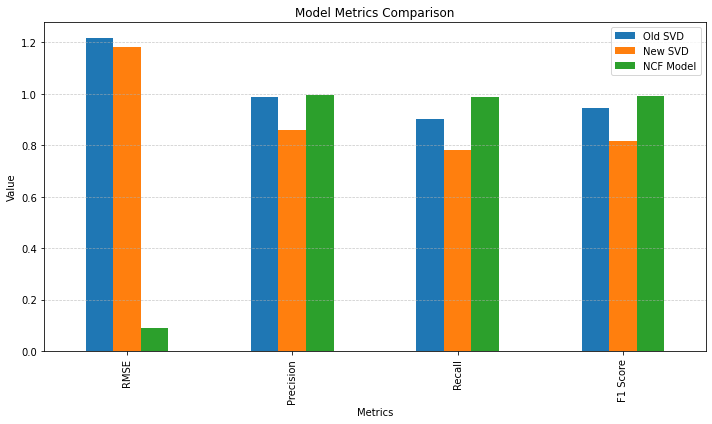

In [226]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))

# Plotting values all three model
df.plot(kind='bar', ax=ax, x='Metrics')

# ploting histogram
ax.set_title('Model Metrics Comparison')
ax.set_ylabel('Value')
ax.set_xlabel('Metrics')
ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()


plt.show()


The code cell below is doing compariosn between SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} , Improved SVD model with parameters  {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and NCF (Neural Collaborative Filtering) model in heatmap form and displaying RMSE, Precision , Recall and F1 score of all three models.

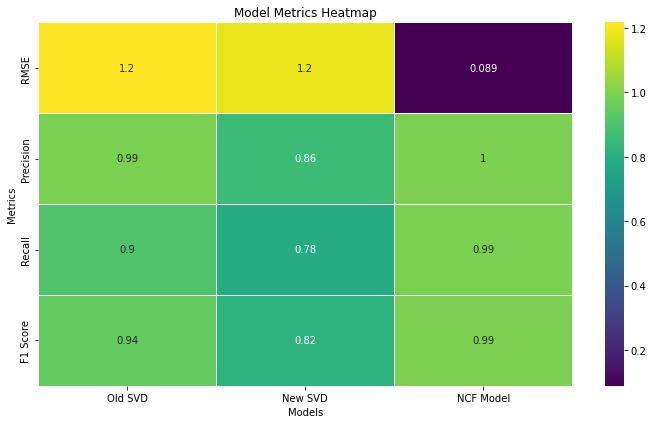

In [230]:
import seaborn as sns

# Preparing data for heatmap and droping Metrices columns.
heatmap_data = df.drop(columns='Metrics').set_index(df['Metrics'])

# Ploating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', linewidths=.)

# setting up heatmap
plt.title('Model Metrics Heatmap')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.tight_layout()


plt.show()


The code cell below is doing compariosn between SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} , Improved SVD model with parameters  {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and NCF (Neural Collaborative Filtering) model in spider chart and displaying RMSE, Precision , Recall and F1 score of all three models.

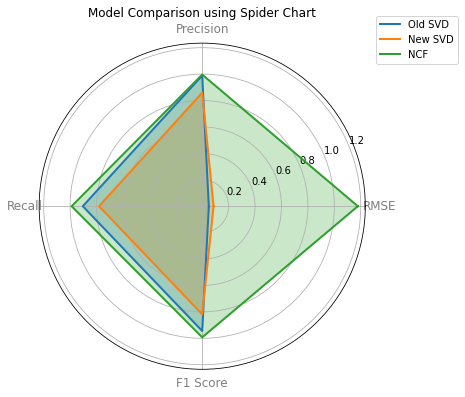

In [235]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['RMSE', 'Precision', 'Recall', 'F1 Score']


old_svd_values = [1.217102048662859, 0.9893, 0.9041, 0.9448]
new_svd_values = [1.1809891560964174, 0.8595, 0.7812, 0.8185]
ncf_values = [0.08896161097623842, 0.9965325482499182, 0.9887698799091205, 0.992636037797328]


max_rmse = max(old_svd_values[0], new_svd_values[0], ncf_values[0])
old_svd_values[0] = max_rmse - old_svd_values[0] + 0.05 # Adding a small constant to ensure positive values
new_svd_values[0] = max_rmse - new_svd_values[0] + 0.05
ncf_values[0] = max_rmse - ncf_values[0] + 0.05

# Create the angle for every axis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1] 

# Setting up figures and axis
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], labels, color='grey', size=12)

# Ploating Old SVD Model metrices
values = old_svd_values
values += values[:1] 
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Old SVD')
ax.fill(angles, values, alpha=0.25)

# Ploating new SVD model Metrices
values = new_svd_values
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='New SVD')
ax.fill(angles, values, alpha=0.25)

# Ploating NCF model Metrices
values = ncf_values
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='NCF')
ax.fill(angles, values, alpha=0.25)

# Adding legend and title
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Model Comparison using Spider Chart')

plt.show()


The code cell below is installing python library plotly.

In [232]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


The code cell below is doing compariosn between SVD model with parameters {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2} , Improved SVD model with parameters  {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02} and NCF (Neural Collaborative Filtering) model in form of interactive graph for by using plotly python library and  displaying RMSE, Precision , Recall and F1 score of all three models.

In [236]:
import plotly.graph_objects as go


models = ['Old SVD', 'New SVD', 'NCF']
labels = ['RMSE', 'Precision', 'Recall', 'F1 Score']
old_svd_values = [1.217102048662859, 0.9893, 0.9041, 0.9448]
new_svd_values = [1.1809891560964174, 0.8595, 0.7812, 0.8185]
ncf_values = [0.08896161097623842, 0.9965325482499182, 0.9887698799091205, 0.992636037797328]
values = [old_svd_values, new_svd_values, ncf_values]

# Creating interactive bar graph.
fig = go.Figure()

for model, val in zip(models, values):
    fig.add_trace(go.Bar(name=model, x=labels, y=val, 
                         text=val,
                         textposition='auto')) 

# Updating layout for better visualization
fig.update_layout(barmode='group', 
                  title="Comparison of Models on Different Metrics",
                  xaxis_title="Metrics",
                  yaxis_title="Values",
                  legend_title="Models")

# Show plot
fig.show()
